In [15]:
!pip install -qU transformers diffusers accelerate safetensors

## Zestaw bibliotek do pracy z modelami generatywnymi

Oto cztery popularne biblioteki wykorzystywane w pracy z modelami generatywnymi, szczególnie przy tworzeniu i modyfikacji obrazów:

---

### 🔹 **transformers**
- **Opis:** Biblioteka od **Hugging Face**, zawierająca modele uczenia maszynowego do przetwarzania języka naturalnego.  
  - Używana głównie w zadaniach NLP, takich jak analiza tekstu, tłumaczenie, generowanie tekstu i inne.

### 🔹 **diffusers**
- **Opis:** Biblioteka implementująca modele generatywne typu **diffusion** do tworzenia obrazów.  
  - Umożliwia generowanie obrazów na podstawie opisów tekstowych lub innych danych wejściowych, przy użyciu nowoczesnych modeli diffusion.

### 🔹 **accelerate**
- **Opis:** Narzędzie do optymalizacji i przyspieszania obliczeń na **GPU**.  
  - Dzięki **accelerate**, obliczenia są znacznie szybsze, co jest szczególnie ważne przy pracy z dużymi modelami i danymi.

### 🔹 **safetensors**
- **Opis:** Format zapisu modeli uczenia maszynowego, który jest **bezpieczniejszy** niż standardowy **pickle**.  
  - Używany do zapisywania i ładowania dużych modeli w sposób bardziej bezpieczny i odporny na błędy.

In [2]:
# Standard library imports
import itertools
from random import sample
import os

import torch
from diffusers import StableDiffusionXLPipeline
from IPython.display import Image

/Users/marcinpilarczyk/projects/python/AI-Notes/_personal/course/gen_ai/day_2/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Konfiguracja modelu Stable Diffusion XL

Ten fragment kodu ustala parametry konfiguracyjne do pracy z modelem **Stable Diffusion XL**. Przeanalizujmy każdy element.

---

### 🔹 **Klasa CFG (Configuration)**
- **Rola:** Przechowuje wszystkie ustawienia potrzebne do pracy z modelem SDXL.

---

### 🔹 **Parametry konfiguracyjne**

#### `model = "stabilityai/stable-diffusion-xl-base-1.0"`
- **Opis:** Określa, którą wersję modelu Stable Diffusion XL należy załadować. Jest to ścieżka do pliku modelu.
- **Zaleta:** Umożliwia systemowi lokalizowanie odpowiedniego modelu.

#### `dtype = torch.float16`
- **Opis:** Ustawia format przechowywania liczb na **16-bitową precyzję** (half precision).  
- **Zaleta:** Zmniejsza zużycie pamięci GPU o połowę, co poprawia wydajność obliczeń.

#### `device = "mps"`
- **Opis:** Określa, że obliczenia będą wykonywane na **Apple Silicon**, a nie na karcie graficznej (GPU).
- **Zaleta:** Przyspiesza obliczenia w porównaniu do CPU.

#### `variant = "fp16"`
- **Opis:** Potwierdza, że używana wersja modelu jest zoptymalizowana pod kątem **16-bitowej precyzji**.
- **Zaleta:** Zapewnia spójność z ustawionym dtype i optymalizuje obliczenia.

#### `seed = 1942`
- **Opis:** Ustawia **ziarno generatora liczb pseudolosowych** na stałą wartość, co zapewnia powtarzalność wyników.
- **Zaleta:** Dzięki temu, przy tych samych parametrach wejściowych, generowane obrazy będą identyczne (przydatne do debugowania).

#### `howmany = 1`
- **Opis:** Określa, że chcemy wygenerować **jeden obraz**.
- **Zaleta:** Umożliwia kontrolowanie liczby wygenerowanych obrazów.

#### `infsteps = 20`
- **Opis:** Ustawia liczbę **kroków inferencji** (iteracji), które model wykona podczas generowania obrazu.
- **Zaleta:** Większa liczba kroków zwykle poprawia jakość obrazu, ale zwiększa czas generowania.

---

### 🔹 **Generator liczb pseudolosowych**
#### `g = torch.Generator(device = CFG.device)`
- **Opis:** Tworzy generator liczb pseudolosowych na karcie graficznej.
- **Zaleta:** Umożliwia kontrolowaną losowość i poprawia wydajność, eliminując potrzebę transferu danych między CPU a GPU.

---

### 🔹 **Podsumowanie:**
Ten zestaw parametrów pozwala na optymalną konfigurację modelu **Stable Diffusion XL**, z naciskiem na **wydajność obliczeniową** oraz **powtarzalność wyników**. Dzięki temu, proces generowania obrazów jest bardziej efektywny i kontrolowany.

In [17]:
class CFG:
    model = "stabilityai/stable-diffusion-xl-base-1.0"
    dtype = torch.float16
    device = "cpu"
    variant = "fp16"
    seed = 1942
    how_many = 1
    infsteps = 40

if torch.backends.mps.is_available():
    CFG.device = "mps"
if torch.cuda.is_available():
    CFG.device = "cuda"


print("Device: ", CFG.device)

# fix randomness
g = torch.Generator(device = CFG.device).manual_seed(CFG.seed)

Device:  cuda


## Konfiguracja zmiennej środowiskowej w Hugging Face

Ten fragment kodu ustawia zmienną środowiskową, która wpływa na sposób działania biblioteki **Hugging Face** i kontroluje mechanizm transferu danych podczas pobierania modeli z **Hugging Face Hub**.

---

### 🔹 **Zmienna środowiskowa - HF_HUB_ENABLE_HF_TRANSFER**

#### `HF_HUB_ENABLE_HF_TRANSFER=1`
- **Opis:** Ta linia ustawia zmienną środowiskową, która włącza nowy system transferu plików w **Hugging Face**.
- **Zaleta:** Włączenie tej opcji sprawia, że **Hugging Face** używa preferowanego systemu przesyłania danych, który:
  - **Zwiększa wydajność** pobierania dużych modeli.
  - **Poprawia stabilność** transferu danych.
  - Jest **bardziej niezawodny**, zwłaszcza przy słabszych połączeniach internetowych.

---

### 🔹 **Bez tej konfiguracji**
- Biblioteka Hugging Face korzysta z **domyślnego, starszego systemu transferu** danych.
- Nowy mechanizm transferu może **przyspieszyć pobieranie modeli** i poprawić jakość połączenia.

---

### 🔹 **Moment wykonania kodu**
- Kod ten należy uruchomić **na początku skryptu**, przed użyciem jakichkolwiek funkcji z biblioteki Hugging Face, ponieważ zmienne środowiskowe muszą być ustawione zanim biblioteka zostanie zainicjalizowana.

---

### 🔹 **Podsumowanie:**
Włączenie tej zmiennej środowiskowej jest korzystne, jeśli zależy Ci na **szybszym** i **bardziej stabilnym** transferze dużych plików z Hugging Face Hub, co może poprawić ogólne działanie aplikacji.


In [18]:
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"

# Eskperyment

## Inicjalizacja silnika generowania obrazów

Ten fragment kodu jest odpowiedzialny za zainicjowanie i skonfigurowanie głównego silnika generowania obrazów. Przyjrzyjmy się, jak działa:

---

### 🔹 **`StableDiffusionXLPipeline.from_pretrained()`**

Metoda ta służy do załadowania wytrenowanego modelu **SDXL** (Stable Diffusion XL). Przekazujemy do niej kilka kluczowych parametrów:

- **`CFG.model`**: Ścieżka do modelu bazowego **SDXL 1.0**, wskazująca, który model ma zostać załadowany.
- **`torch_dtype=CFG.dtype`**: Określenie typu danych na **float16**. Jest to ważne, ponieważ ten typ danych zajmuje mniej pamięci na GPU, co przekłada się na oszczędności pamięci i szybsze obliczenia.
- **`variant=CFG.variant`**: Określenie wariantu modelu. W tym przypadku, wariant **fp16** to model zoptymalizowany pod kątem liczby zmiennoprzecinkowych o połowicznej precyzji (16-bitowej).
- **`use_safetensors=True`**: Użycie bezpiecznego formatu **safetensors** do wczytywania modelu. Zapewnia to większe bezpieczeństwo i integralność danych w porównaniu do tradycyjnego formatu **pickle**.

---

### 🔹 **`model.to(CFG.device)`**

- **`model.to(CFG.device)`**: Ta metoda przenosi model na urządzenie określone w zmiennej **`CFG.device`**. W naszym przypadku, **cuda** (czyli GPU), co umożliwia szybsze obliczenia w porównaniu do CPU.

---

### 🔹 **Zapisanie w zmiennej `pipe`**

Cały proces ładowania i konfiguracji modelu kończy się przypisaniem obiektu **pipeline** do zmiennej **`pipe`**. Będzie ona wykorzystywana później do generowania obrazów przy użyciu załadowanego modelu.

---

### 🔹 **Podsumowanie**

- Inicjalizacja tego pipeline’u jest kluczowym krokiem do **uruchomienia generowania obrazów** za pomocą modelu **Stable Diffusion XL**.
- Użycie modelu w wersji **fp16** i przeniesienie go na **GPU** zapewnia **wydajność** oraz **oszczędności pamięci**.


In [19]:
pipe = StableDiffusionXLPipeline.from_pretrained(
    CFG.model,
    generator = g,
    torch_dtype = CFG.dtype,
    variant = CFG.variant,
    use_safetensors=True).to(CFG.device)

# Recommended if your computer has < 64 GB of RAM
pipe.enable_attention_slicing()

Keyword arguments {'generator': <torch._C.Generator object at 0x7a4a47937cb0>} are not expected by StableDiffusionXLPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [20]:
# prepare the prompts
gender_list = ['woman', 'man']

origin_list = [ 'North European',   'South American', 'Middle Eastern', 'South East Asian' ]

age_list = ['young', 'middle aged', 'elderly']

profession_list = ['lawyer', 'doctor', 'athlete', 'singer']

In [21]:
totality =  [origin_list, age_list, gender_list, profession_list ]
combo = itertools.product(*totality)
combo_list = []
for f in combo:
    combo_list.append(f)

In [22]:
prompt_list = []
for (ii, xx) in enumerate(combo_list):
    prom = "High-definition, cinematic, full-body photograph of "  + xx[0] + " " + xx[1] + " " + xx[2] + " " + xx[3]
    prompt_list.append(prom)

prompt_list[0:3]

['High-definition, cinematic, full-body photograph of North European young woman lawyer',
 'High-definition, cinematic, full-body photograph of North European young woman doctor',
 'High-definition, cinematic, full-body photograph of North European young woman athlete']

## Proces generowania obrazów

Ten fragment kodu odpowiada za **generowanie obrazów** przy użyciu wybranego zestawu promptów. Oto szczegółowe wyjaśnienie krok po kroku:

---

### 🔹 **Losowy wybór promptów**

- **`sample()`**: Funkcja ta losowo wybiera tylko dwa prompty z pełnej listy dostępnych opisów. Dzięki temu przyspieszamy proces testowy, zachowując jednocześnie różnorodność generowanych obrazów.

---

### 🔹 **Zagnieżdżona struktura pętli**

Zostały zastosowane dwie pętle:

- **Zewnętrzna pętla** (z `enumerate`): Iteruje przez wybrane prompty.
- **Wewnętrzna pętla** (`range(CFG.howmany)`): Określa, ile wariantów danego obrazu chcemy wygenerować. Ponieważ **`CFG.howmany = 1`**, ta pętla wykona się tylko raz dla każdego promptu, generując pojedynczy wariant obrazu.

---

### 🔹 **Generowanie obrazów**

W każdej iteracji wewnętrznej pętli wykonywane są następujące kroki:

1. **`pipe(prompt=prompt)`**: Wywołuje nasz skonfigurowany wcześniej generator obrazów, który wykorzystuje aktualny prompt do wygenerowania obrazu.
   
2. **`.images[0]`**: Pobiera pierwszy (i jedyny) wygenerowany obraz z wyników zwróconych przez pipeline.

3. **`img_IxJ.jpg`**: Konstruujemy nazwę pliku obrazu w formacie "img_IIxJJ.jpg", gdzie:
   - **I** to numer promptu (indeks w liście).
   - **J** to numer wariantu obrazu (w tym przypadku zawsze `1`, bo generujemy tylko jeden wariant).

4. **`save()`**: Zapisujemy obraz do pliku z wcześniej skonstruowaną nazwą.

---

### 🔹 **Wyświetlanie promptu**

- **`print(prompt)`**: Po zapisaniu obrazu, wyświetlamy użyty prompt. To pozwala na łatwe śledzenie, jaki opis tekstowy został użyty do wygenerowania konkretnego obrazu.

---

### 🔹 **Podsumowanie**

- Kod umożliwia **generowanie obrazów** na podstawie opisów tekstowych z wykorzystaniem modelu generatywnego.
- Dzięki zastosowaniu **losowego wyboru promptów** oraz **zagnieżdżonych pętli** kontrolujemy, ile obrazów generujemy i jak je zapisujemy.
- **Unikalne nazwy plików** powiązane z numerami promptów oraz wariantów pomagają w organizacji wyników.
- Wyświetlanie użytego promptu pozwala na szybką weryfikację, który opis tekstowy wygenerował dany obraz.



In [23]:
## subset to run faster
prompt_list = sample(prompt_list, k=4)

for (i, prompt) in enumerate(prompt_list):
    for j in range(CFG.how_many):
        image = pipe(prompt=prompt, num_inference_steps = CFG.infsteps, generator = g).images[0]
        img_name = "img_" + str(i) + "x" + str(j) + ".jpg"
        image = image.save(img_name)
        print(prompt)

  0%|          | 0/40 [00:00<?, ?it/s]

High-definition, cinematic, full-body photograph of South American young woman lawyer


  0%|          | 0/40 [00:00<?, ?it/s]

High-definition, cinematic, full-body photograph of North European elderly man doctor


  0%|          | 0/40 [00:00<?, ?it/s]

High-definition, cinematic, full-body photograph of North European elderly woman singer


  0%|          | 0/40 [00:00<?, ?it/s]

High-definition, cinematic, full-body photograph of North European young woman doctor


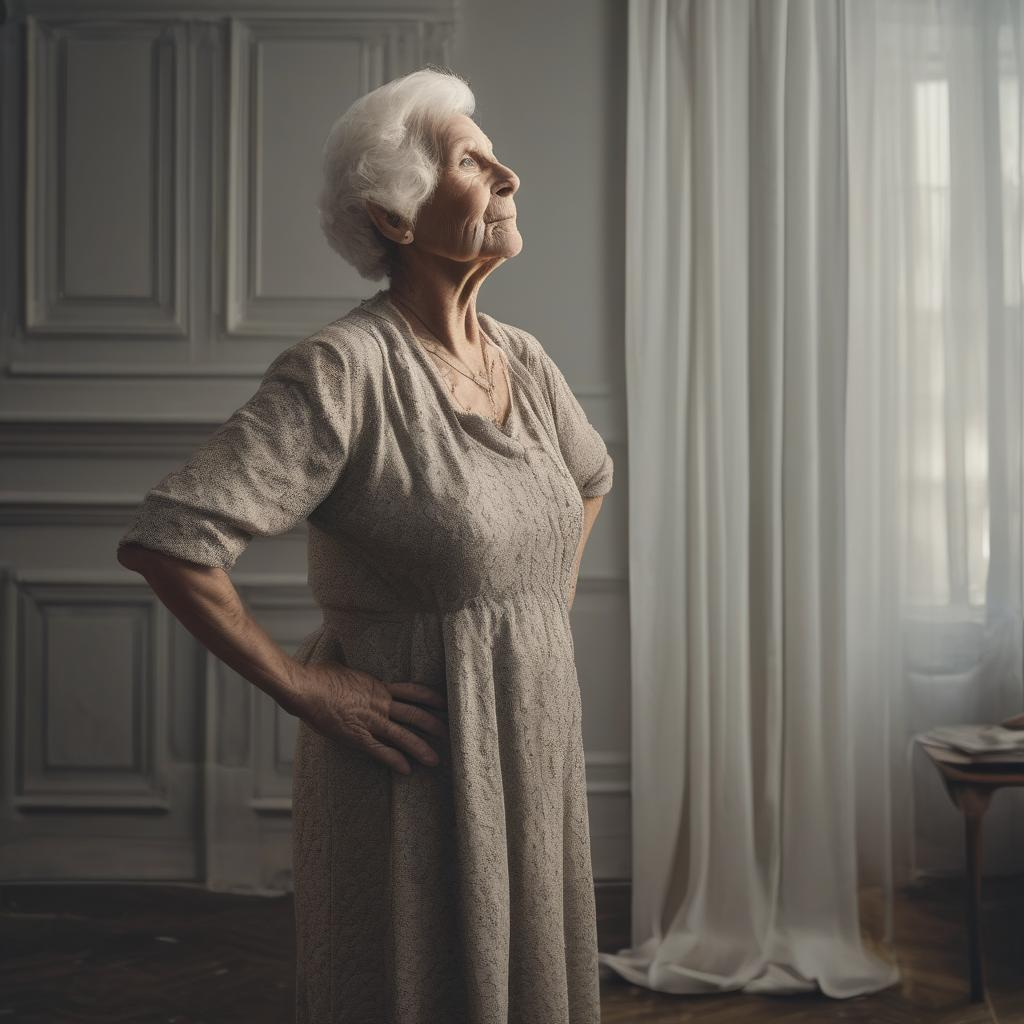

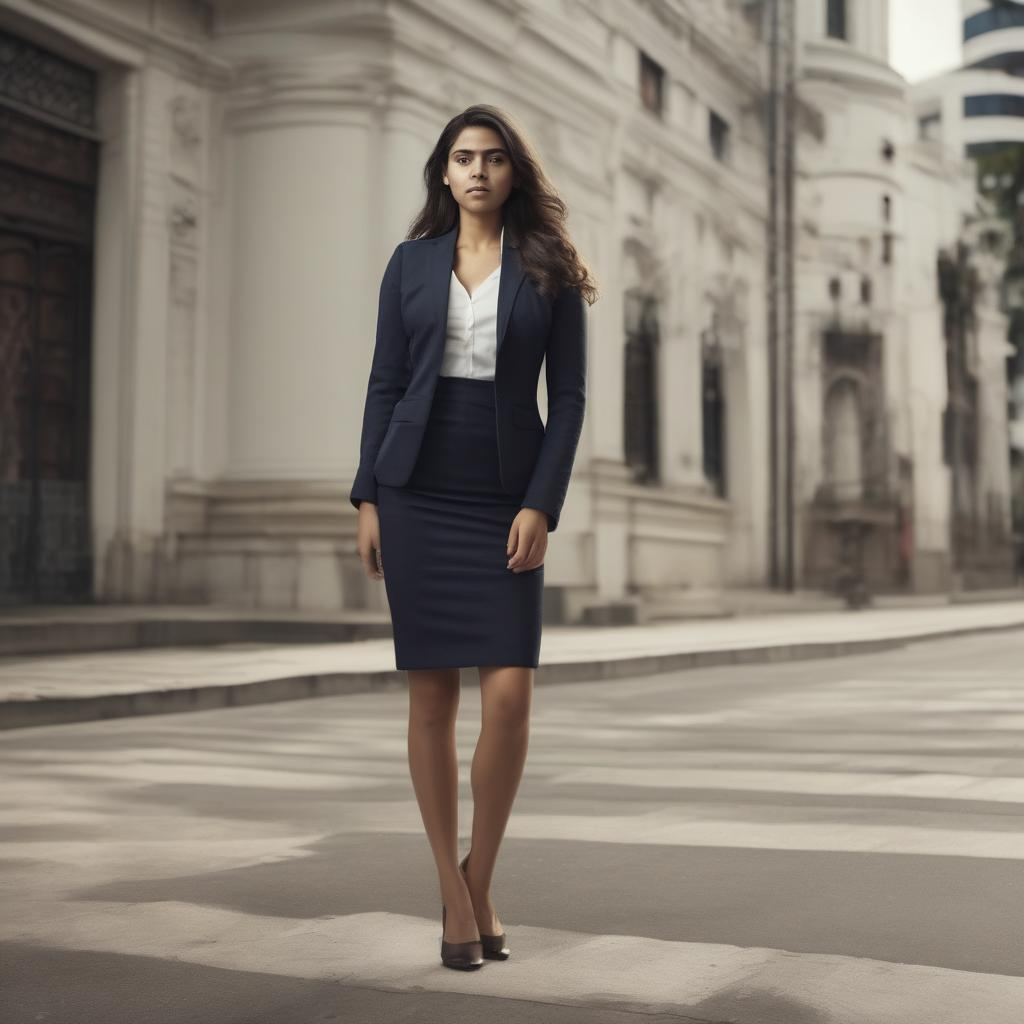

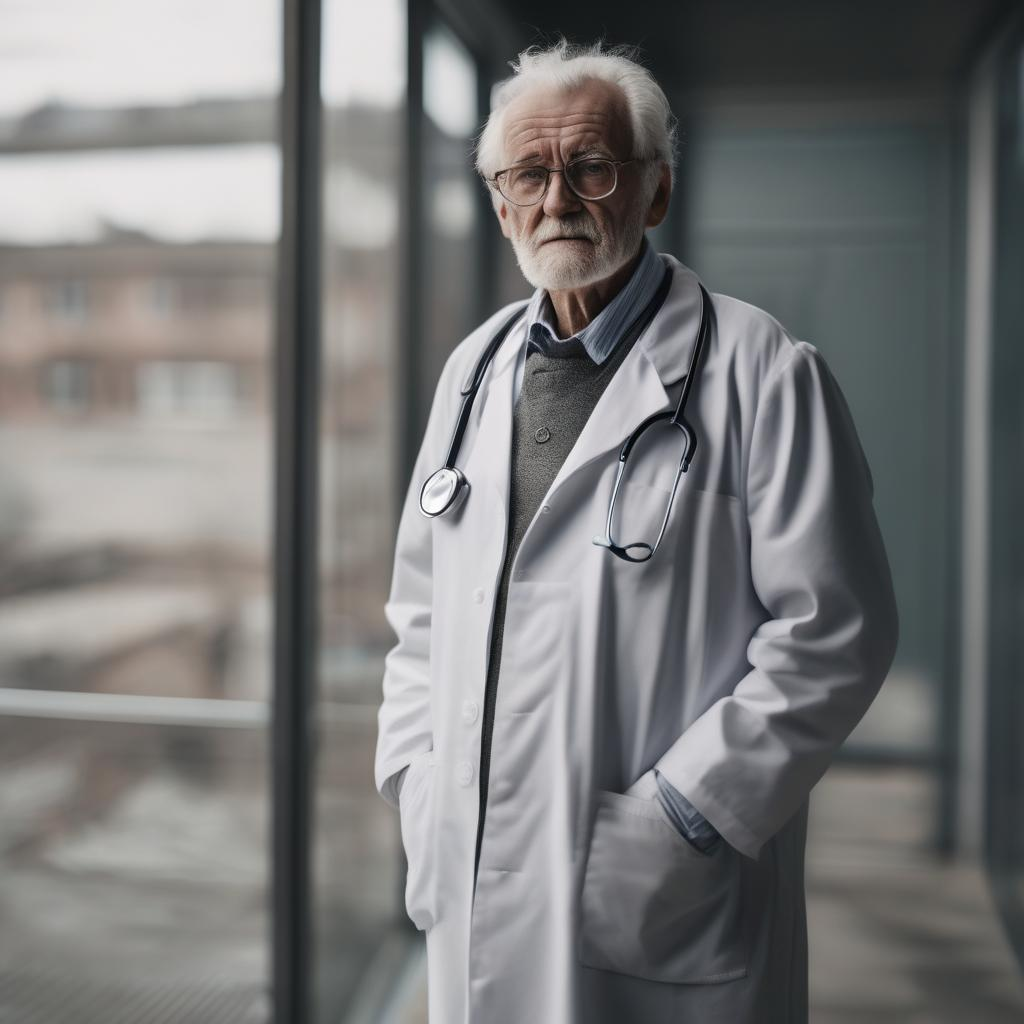

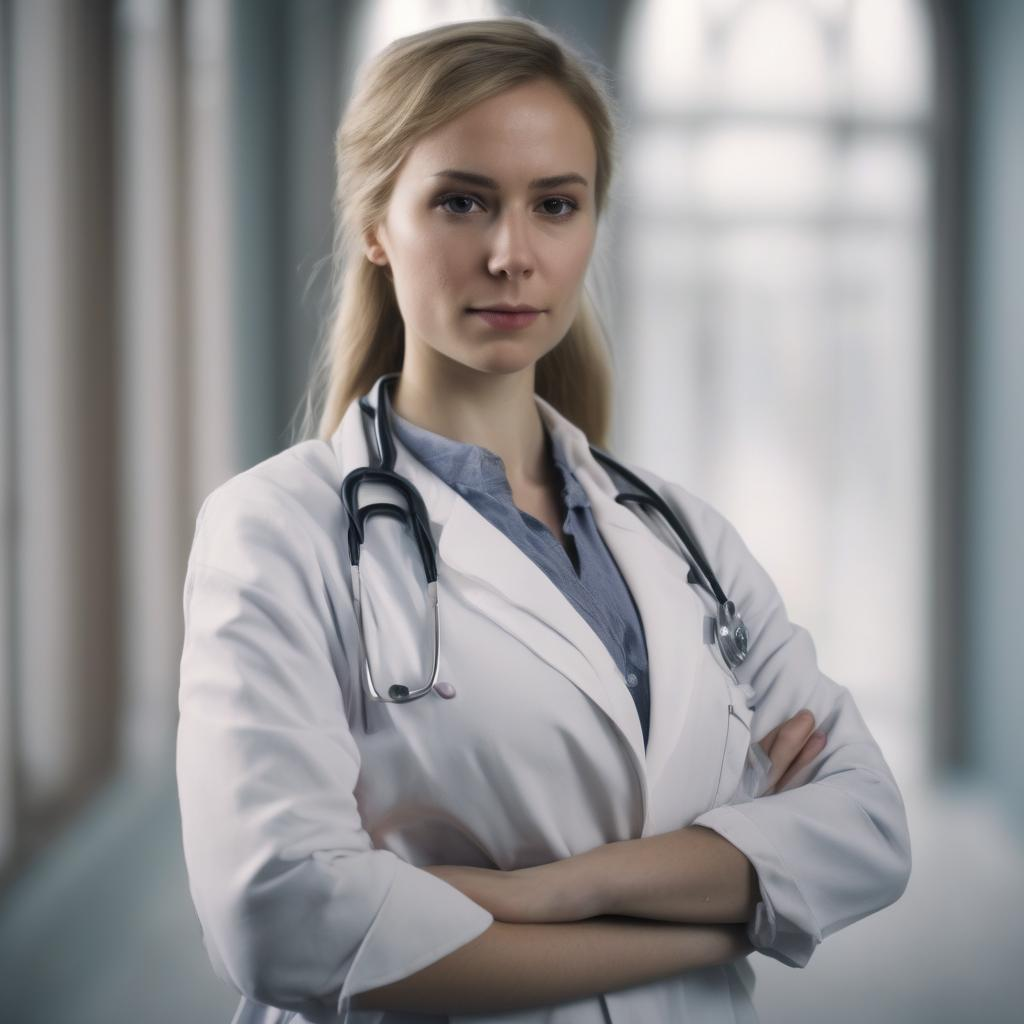

In [3]:
import glob
for file in glob.glob("*.jpg"):
    display(Image(filename=file))